# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 28.01.2022

Мягкий дедлайн: 23:59MSK 14.02.2022

Жесткий дедлайн: 23:59MSK 17.02.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
# from lightgbm import LGBMClassifier
from random import sample
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from time import time
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
        self.w = None
        self.b = None

        self.final_model = None

        # так как для тестовой выборки тоже придется делать
        self.pca_model = None
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA:
            self.pca_model = PCA(self.new_dim)
            fit = self.pca_model.fit(X)
            X = fit.transform(X)
        else:
            self.new_dim = X.shape[1]
            X = X.astype(float)

        sz = 1000
        left = np.random.random_integers(0, int(len(X)/2 - 2), size = sz)
        right =  np.random.random_integers(int(len(X)/2), int(len(X) - 2), size = sz)
        
        sum_arr = []

        for i in range(sz):
            for j in range(sz):
                sum_arr.append( ((X[left[i]] - X[right[j]])**2).sum() )
        
        sigma = np.median(sum_arr)
        self.w = np.random.normal(0, 1/(sigma**0.5), (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        X = np.cos(X.dot(self.w) + np.tile(self.b, (len(X), 1)))

        if(self.classifier=='svm'):
            self.final_model = SVC(kernel='linear')
            self.final_model.fit(X, y)
        
        if(self.classifier=='logreg'):
            self.final_model = LogisticRegression()
            self.final_model.fit(X, y)

        if(self.classifier=='svm_kernel'):
            self.final_model = SVC(kernel='rbf')
            self.final_model.fit(X, y)
        
        return self
        raise NotImplementedError

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA:
            X = self.pca_model.transform(X)
            X = np.cos(X.dot(self.w) + np.tile(self.b, (len(X), 1)))
            return self.final_model.predict_proba(X)  
        
        X = X.astype(float)
        X = np.cos(X.dot(self.w) + np.tile(self.b, (len(X), 1)))
        return self.final_model.predict_proba(X)  

        raise NotImplementedError
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        
        if self.use_PCA:
            X = self.pca_model.transform(X)
            X = np.cos(X.dot(self.w) + np.tile(self.b, (len(X), 1)))
            return self.final_model.predict(X)
        
        X = X.astype(float)
        X = np.cos(X.dot(self.w) + np.tile(self.b, (len(X), 1)))
        return self.final_model.predict(X)
        raise NotImplementedError

In [4]:
y_pred = RFFPipeline().fit(x_train, y_train).predict(x_test)
print('Accuracy = ', accuracy_score(y_test, y_pred))

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy =  0.8602


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

start = time()
model = RFFPipeline(classifier='svm').fit(x_train, y_train)
train_time = time() - start

start = time()
y_pred = model.predict(x_test)
pred_time = time() - start
l_svm = accuracy_score(y_test, y_pred)

print(f'Linear svm accuracy = {l_svm}\n',
    f'Время обучения: {train_time}\n',
    f'Время применения: {pred_time}')

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead


Linear svm accuracy = 0.8815
 Время обучения: 423.54838585853577
 Время применения: 78.11897492408752


In [6]:
start = time()
model = RFFPipeline(classifier='svm_kernel').fit(x_train, y_train)
train_time = time() - start

start = time()
y_pred = model.predict(x_test)
pred_time = time() - start
k_svm = accuracy_score(y_test, y_pred)

print(f'Linear svm accuracy = {k_svm}\n',
    f'Время обучения: {train_time}\n',
    f'Время применения: {pred_time}')

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead


Linear svm accuracy = 0.8665
 Время обучения: 365.8861081600189
 Время применения: 167.91744089126587


In [14]:
from lightgbm import LGBMClassifier

arr_lrs = [0.1, 0.3, 0.6]
estimators = [200, 400, 700]

res_acc = 0
res_est = 0
res_lr = 0

train_time = 0
apply_time = 0

for lr in arr_lrs:
    for n_est in estimators:
        pca = PCA(n_components=50)
        pca.fit(x_train)
        x_train_ = pca.transform(x_train) 
        x_test_ = pca.transform(x_test)
        model = LGBMClassifier(learning_rate=lr, n_estimators=n_est)

        start = time()
        model = model.fit(x_train_, y_train)
        tmp_tr = time() - start
        
        start = time()
        y_pred = model.predict(x_test_)
        tmp_pr = time() - start
        
        y_check = model.predict(x_train_)
        
        acc = accuracy_score(y_test, y_pred)
        st = accuracy_score(y_train, y_check)
        print(f'lr = {lr} \t n_est = {n_est} \t accuracy = {acc} \t контроль переобучения {st}')

        if accuracy_score(y_test, y_pred) > res_acc:
            res_acc = accuracy_score(y_test, y_pred)
            res_est = n_est
            res_lr = lr
            train_time = tmp_tr
            apply_time = tmp_pr

lr = 0.1 	 n_est = 200 	 accuracy = 0.8752 	 контроль переобучения 0.9962333333333333
lr = 0.1 	 n_est = 400 	 accuracy = 0.8781 	 контроль переобучения 1.0
lr = 0.1 	 n_est = 700 	 accuracy = 0.8827 	 контроль переобучения 1.0
lr = 0.3 	 n_est = 200 	 accuracy = 0.223 	 контроль переобучения 0.22585
lr = 0.3 	 n_est = 400 	 accuracy = 0.581 	 контроль переобучения 0.6025
lr = 0.3 	 n_est = 700 	 accuracy = 0.4721 	 контроль переобучения 0.4873
lr = 0.6 	 n_est = 200 	 accuracy = 0.5381 	 контроль переобучения 0.5487333333333333
lr = 0.6 	 n_est = 400 	 accuracy = 0.5886 	 контроль переобучения 0.60295
lr = 0.6 	 n_est = 700 	 accuracy = 0.1872 	 контроль переобучения 0.19561666666666666


In [15]:
print(f'Лучшее качество: {res_acc}, достигается с параметрами lr = {res_lr}, n_estimators = {res_est}')

print(f'Время обучения {train_time} Время применения {apply_time}')

Лучшее качество: 0.8827, достигается с параметрами lr = 0.1, n_estimators = 700
Время обучения 37.9368360042572 Время применения 1.185028076171875


__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [16]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
y_pred = RFFPipeline().fit(x_train, y_train).predict(x_test)
acc_sc = accuracy_score(y_test, y_pred)
print(f'logreg accuracy using PCA= {acc_sc}')

y_pred = RFFPipeline(use_PCA=False).fit(x_train, y_train).predict(x_test)
acc_sc = accuracy_score(y_test, y_pred)
print(f'logreg accuracy without PCA= {acc_sc}')

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


logreg accuracy using PCA= 0.8614


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


logreg accuracy without PCA= 0.8622


In [9]:
accur = []
feats = [50, 100, 150, 250, 500, 1000, 1500, 3000, 4000, 6000, 8000]
for amount in feats:
    y_pred = RFFPipeline(n_features=amount).fit(x_train, y_train).predict(x_test)
    acc_sc = accuracy_score(y_test, y_pred)
    accur.append(acc_sc)

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This functio

/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

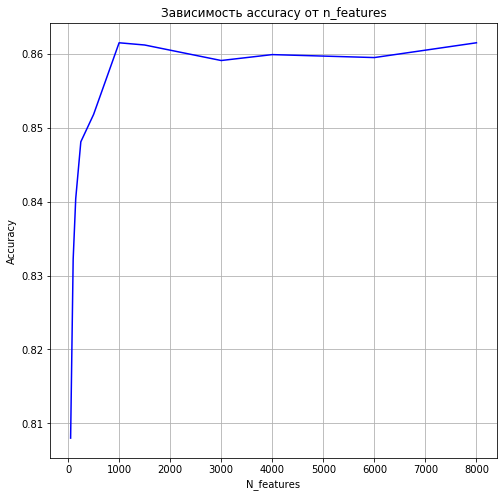

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(feats, accur, color = 'b')
plt.ylabel('Accuracy')
plt.xlabel('N_features')
plt.grid()
plt.title("Зависимость accuracy от n_features")
plt.show()

In [12]:
svm_pca_y = RFFPipeline(classifier='svm', use_PCA=True).fit(x_train, y_train).predict(x_test)
svm_pca_acc_y =  accuracy_score(y_test, svm_pca_y)

svm_y = RFFPipeline(classifier='svm', use_PCA=False).fit(x_train, y_train).predict(x_test)
svm_acc_y =  accuracy_score(y_test, svm_y)

lr_pca_y = RFFPipeline().fit(x_train, y_train).predict(x_test)
lr_pca_acc_y =  accuracy_score(y_test, lr_pca_y)

lr_y = RFFPipeline(use_PCA=False).fit(x_train, y_train).predict(x_test)
lr_acc_y =  accuracy_score(y_test, lr_y)


/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please call randint(30000, 59998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. Please call randint(0, 29998 + 1) instead
/Users/umni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: This function is deprecated. Please c

In [13]:
print(f'Accuracy for linear svm using PCA = \t {svm_pca_acc_y}')
print(f'Accuracy for linear svm without PCA = \t {svm_acc_y}')
print(f'Accuracy for logistic regression = \t {lr_pca_acc_y}')
print(f'Accuracy for logistic regression without PCA = \t {lr_acc_y}')

pca = svm_pca_acc_y - lr_pca_acc_y
wpca = svm_acc_y - lr_acc_y
print(f'PCA difference {pca}')
print(f'Without PCA difference {wpca}')

Accuracy for linear svm using PCA = 	 0.8839
Accuracy for linear svm without PCA = 	 0.8608
Accuracy for logistic regression = 	 0.8595
Accuracy for logistic regression without PCA = 	 0.8604
PCA difference 0.024399999999999977
Without PCA difference 0.00039999999999995595


### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪